# Vodafone COPS. Model performance measurement

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import (roc_auc_score, auc, roc_curve, 
                             f1_score, precision_recall_curve, 
                             recall_score, precision_score, accuracy_score,
                             average_precision_score, confusion_matrix)

%matplotlib inline

sns.set_style('white')

kernel_blue = '#005379'
kernel_orange = '#d46235'
kernel_gray = '#BFBFBF'

plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%autosave 60

Autosaving every 60 seconds


In [217]:
# Utilities

def adjust_proba(p, positive_label_real, positive_label_balanced):
    """
    Adjust probability for models trained with unbalanced data.
    """
    
    p_adjusted = (p * (1 - positive_label_balanced) * positive_label_real)\
                 / ((1 - p) * positive_label_balanced * (1 - positive_label_real)\
                 + p * (1 - positive_label_balanced) * positive_label_real)
    return p_adjusted

def plot_roc(true_labels, scores):
    """
    Plots roc curve.
    """
    fpr, tpr, thr = roc_curve(true_labels, scores)
    area_under_curve = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, 
             tpr, 
             color=kernel_orange,
             label='ROC curve (area = %0.2f)' % area_under_curve)
    plt.plot(fpr, 
             thr, 
             color=kernel_gray,
             lw=2,
             linestyle=':', label='Threshold value (y axis)')
    plt.plot([0, 1], [0, 1], color=kernel_blue, lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_lift(probability, truelabel, prediction, n_buckets=100):
    """
    Plots lift chart.
    """
    
    df_lift = pd.DataFrame({'probability': probability, 
                            'label': truelabel, 
                            'prediction': prediction})
    
    df_lift.sort_values('probability', ascending=False, inplace=True)
    df_lift['bucket'] = pd.qcut(df_lift['probability'], n_buckets, duplicates='drop')
    df_lift = df_lift.groupby('bucket')['probability', 'label'].mean() \
                / [df_lift['probability'].mean(), df_lift['label'].mean()]
    resulting_buckets = len(df_lift)
    df_lift['bucket'] = (resulting_buckets - df_lift.index.codes).astype('object')
    df_lift = df_lift.set_index('bucket')
    df_lift.plot(kind='line', xlim=(0, resulting_buckets), color=[kernel_blue, kernel_orange])
    ax = plt.gca()
    start, end = ax.get_xlim()
    stepsize = 1.0
    # ax.xaxis.set_ticks(np.arange(start + 1, end + 1, stepsize))
    ax.axhline(y=1.0, linestyle=":", c='black')
    ax.axvline(x=1.0, linestyle=":", c='black')
    ax.legend(["Pred", "True"])
    ax.set_title("Lift chart")
    ax.set_ylabel("Lift")
    ax.set_xlabel("Bucket")
    plt.show()
    
def plot_cumulative_gains(results, n_buckets=100):
    """
    Plots cumulative gain.
    """
    
    df_cum_gain_train = pd.DataFrame({'label': results['train']['labels'],
                                      'probability': results['train']['prob']})
    df_cum_gain_test_1 = pd.DataFrame({'label': results['test_1']['labels'],
                                       'probability': results['test_1']['prob']})
    df_cum_gain_test_2 = pd.DataFrame({'label': results['test_2']['labels'],
                                       'probability': results['test_2']['prob']})
    
    df_cum_gain_train.sort_values('probability', ascending=False, inplace=True)
    df_cum_gain_test_1.sort_values('probability', ascending=False, inplace=True)
    df_cum_gain_test_2.sort_values('probability', ascending=False, inplace=True)
    
    df_cum_gain_train['bucket'] = pd.qcut(df_cum_gain_train['probability'], n_buckets, duplicates='drop')
    df_cum_gain_test_1['bucket'] = pd.qcut(df_cum_gain_test_1['probability'], n_buckets, duplicates='drop')
    df_cum_gain_test_2['bucket'] = pd.qcut(df_cum_gain_test_2['probability'], n_buckets, duplicates='drop')
    
    df_cum_gain_grouped_sum_train = df_cum_gain_train.groupby('bucket').sum()
    df_cum_gain_grouped_sum_test_1 = df_cum_gain_test_1.groupby('bucket').sum()
    df_cum_gain_grouped_sum_test_2 = df_cum_gain_test_2.groupby('bucket').sum()

    
    df_cum_gain_grouped_cumsum_train = df_cum_gain_grouped_sum_train[::-1][['label']].cumsum()
    df_cum_gain_grouped_cumsum_test_1 = df_cum_gain_grouped_sum_test_1[::-1][['label']].cumsum()
    df_cum_gain_grouped_cumsum_test_2 = df_cum_gain_grouped_sum_test_2[::-1][['label']].cumsum()
    
    df_cum_gain_grouped_cumsum_ratio_train = df_cum_gain_grouped_cumsum_train * 100 \
                                            /df_cum_gain_train['label'].sum()
    df_cum_gain_grouped_cumsum_ratio_test_1 = df_cum_gain_grouped_cumsum_test_1 * 100 \
                                                /df_cum_gain_test_1['label'].sum()
    df_cum_gain_grouped_cumsum_ratio_test_2 = df_cum_gain_grouped_cumsum_test_2 * 100 \
                                                /df_cum_gain_test_2['label'].sum()
    
    resulting_buckets = len(df_cum_gain_grouped_cumsum_ratio_train)
    df_cum_gain_grouped_cumsum_ratio_train['bucket'] = (resulting_buckets - df_cum_gain_grouped_cumsum_ratio_train.index.codes).astype('object')
    df_cum_gain_grouped_cumsum_ratio_test_1['bucket'] = (resulting_buckets - df_cum_gain_grouped_cumsum_ratio_test_1.index.codes).astype('object')
    df_cum_gain_grouped_cumsum_ratio_test_2['bucket'] = (resulting_buckets - df_cum_gain_grouped_cumsum_ratio_test_2.index.codes).astype('object')

    df_cum_gain_grouped_cumsum_ratio_train = df_cum_gain_grouped_cumsum_ratio_train.set_index('bucket')
    df_cum_gain_grouped_cumsum_ratio_test_1 = df_cum_gain_grouped_cumsum_ratio_test_1.set_index('bucket')
    df_cum_gain_grouped_cumsum_ratio_test_2 = df_cum_gain_grouped_cumsum_ratio_test_2.set_index('bucket')

    df_cum_gain_grouped_cumsum_ratio_train.loc[0] = 0
    df_cum_gain_grouped_cumsum_ratio_test_1.loc[0] = 0
    df_cum_gain_grouped_cumsum_ratio_test_2.loc[0] = 0
    
    df_cum_gain_grouped_cumsum_ratio_train.sort_index(inplace=True)
    df_cum_gain_grouped_cumsum_ratio_test_1.sort_index(inplace=True)
    df_cum_gain_grouped_cumsum_ratio_test_2.sort_index(inplace=True)

    df_cum_gain_grouped_cumsum_ratio_train['label'].plot(kind='line', 
                                                         xlim=(0, resulting_buckets), 
                                                         color='red', 
                                                         linestyle=':')
    df_cum_gain_grouped_cumsum_ratio_test_1['label'].plot(kind='line', 
                                                          xlim=(0, resulting_buckets),
                                                          color=kernel_blue)
    df_cum_gain_grouped_cumsum_ratio_test_2['label'].plot(kind='line', 
                                                          xlim=(0, resulting_buckets), 
                                                          color=kernel_orange)
    
    ax = plt.gca()
    start, end = ax.get_xlim()
    plt.plot([0, end], [0, 100], color=kernel_gray, lw=1, linestyle='--')
    plt.axvline(x=10, linestyle='--', lw=1, color=kernel_gray)
    ax.legend(["Train", "Test 1", "Test 2", "Baseline"])
    ax.set_title("Cumulative Gain chart")
    ax.set_ylabel("%")
    ax.set_xlabel("Bucket")
    plt.show()

def display_confusion_matrix(predictions, true_labels):
    """
    Display confusion matrix
    """
    cnf_matrix = pd.DataFrame(columns=pd.MultiIndex.from_product([['True label'],[0, 1]]), 
                              index=pd.MultiIndex.from_product([['Predicted label'],[0, 1]]),
                              data=confusion_matrix(predictions, true_labels))
    display(cnf_matrix)

def compute_result_arrays(results_df, 
                          positive_label_real, 
                          positive_label_balanced):
    probabilities = results_df['probability'].values
    probabilities_adjusted = results_df['probability']\
                                           .apply(adjust_proba, 
                                            args=(positive_label_real, 
                                            positive_label_balanced))\
                                           .values
            
    labels = results_df['label'].values
    predictions = results_df['prediction'].values
    
    return probabilities, probabilities_adjusted, labels, predictions

## Data loading

In [218]:
cols = ['probability', 'prediction', 'label']

train_results = pd.read_csv("../data/train_local_predictions.csv", usecols=cols)
test_1_results = pd.read_csv("../data/test_1_local_predictions.csv", usecols=cols)
test_2_results = pd.read_csv("../data/test_2_local_predictions.csv", usecols=cols)

display(test_1_results.head())
display(test_2_results.head())
display(train_results.head())

positive_label_balanced = train_results['label'].sum() / len(train_results)
positive_label_real_1 = test_1_results['label'].sum() / len(test_1_results)
positive_label_real_2 = test_1_results['label'].sum() / len(test_2_results)

# Probability, labels and predictions...

(probabilities_train, 
 probabilities_train_adjusted, 
 labels_train, 
 predictions_train) = compute_result_arrays(train_results, 
                                            positive_label_real, 
                                            positive_label_balanced)    

(probabilities_test_1, 
 probabilities_test_1_adjusted, 
 labels_test_1, 
 predictions_test_1) = compute_result_arrays(test_1_results, 
                                             positive_label_real_1, 
                                             positive_label_balanced)   

(probabilities_test_2, 
 probabilities_test_2_adjusted, 
 labels_test_2, 
 predictions_test_2) = compute_result_arrays(test_2_results,
                                             positive_label_real_2, 
                                             positive_label_balanced)

results = {
    'train': {'prob': probabilities_train, 
              'prob_adj': probabilities_train_adjusted, 
              'labels': labels_train, 
              'pred': predictions_train},
    'test_1': {'prob': probabilities_test_1, 
              'prob_adj': probabilities_test_1_adjusted, 
              'labels': labels_test_1, 
              'pred': predictions_test_1},
    'test_2': {'prob': probabilities_test_2, 
              'prob_adj': probabilities_test_2_adjusted, 
              'labels': labels_test_2, 
              'pred': predictions_test_2},
}

,label,prediction,probability
0,1,0,0.055328
1,1,0,0.054970
2,1,0,0.023630
3,1,0,0.044750
4,1,0,0.016378


,label,prediction,probability
0,1,0,0.031449
1,1,0,0.039731
2,1,0,0.021360
3,1,0,0.077862
4,1,0,0.018426


,label,prediction,probability
0,1,0,0.018051
1,1,0,0.012800
2,1,0,0.015721
3,1,0,0.043025
4,1,0,0.072335


## ROC Curves

### Training set

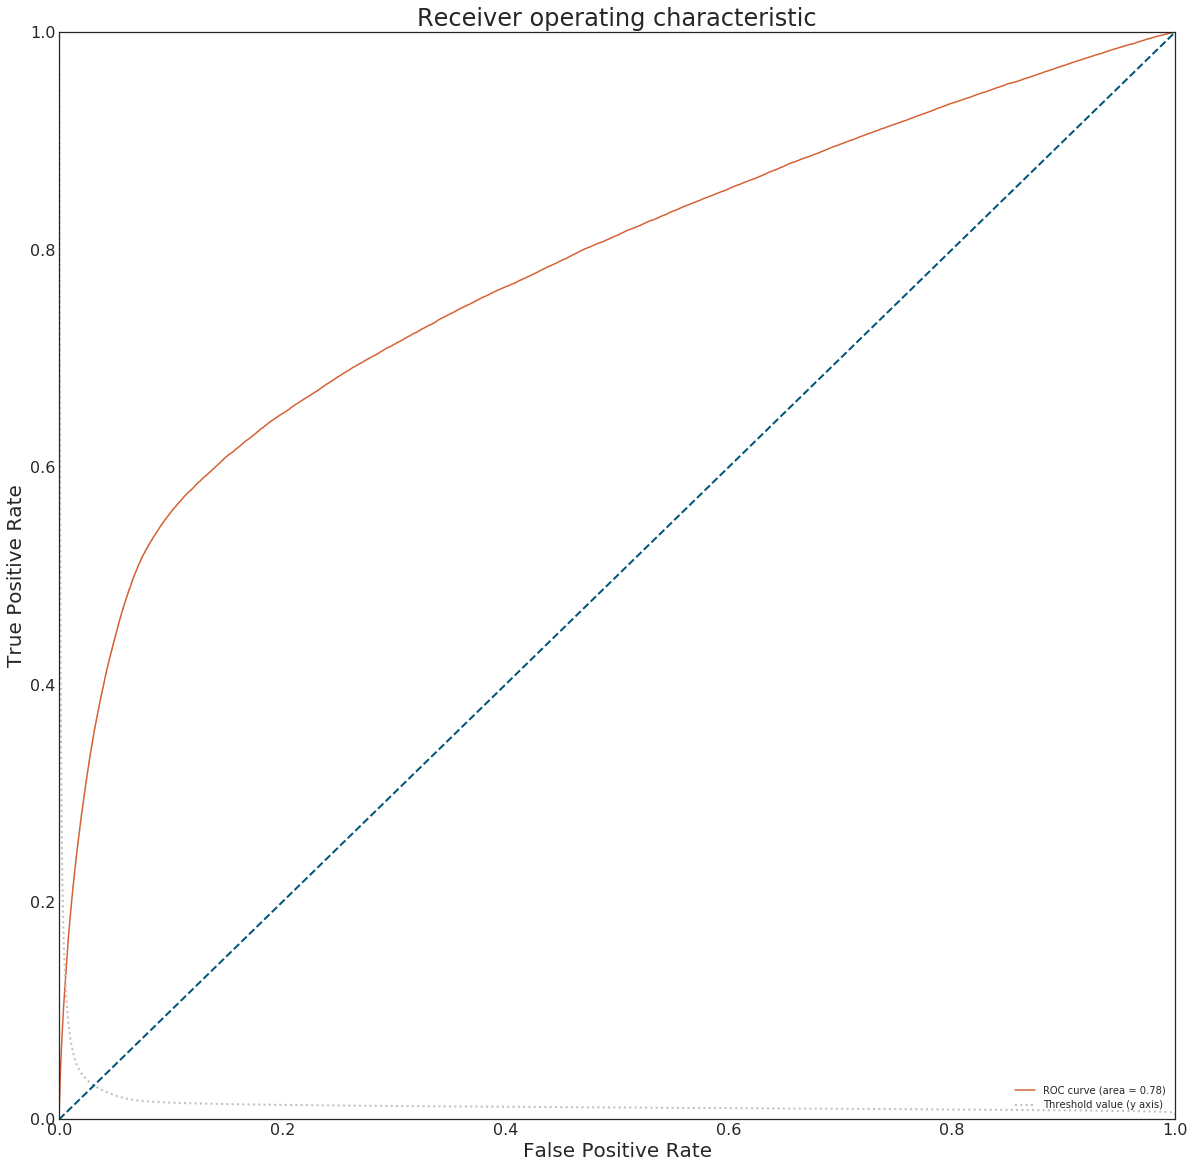

In [219]:
plot_roc(labels_train, probabilities_train)

### Test set 1

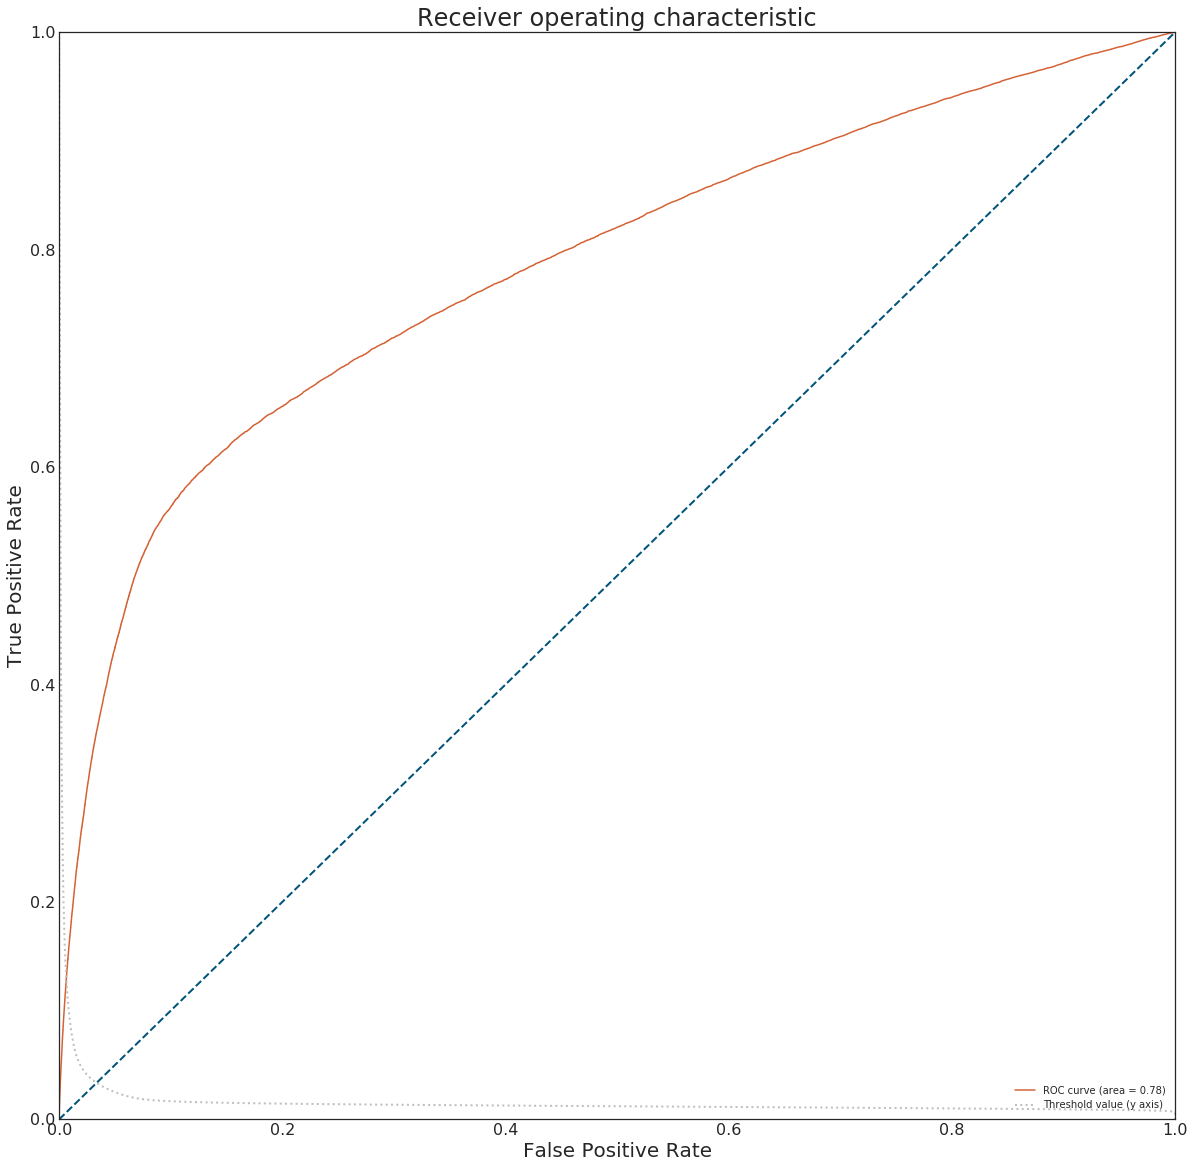

In [220]:
plot_roc(labels_test_1, probabilities_test_1)

### Test set 2

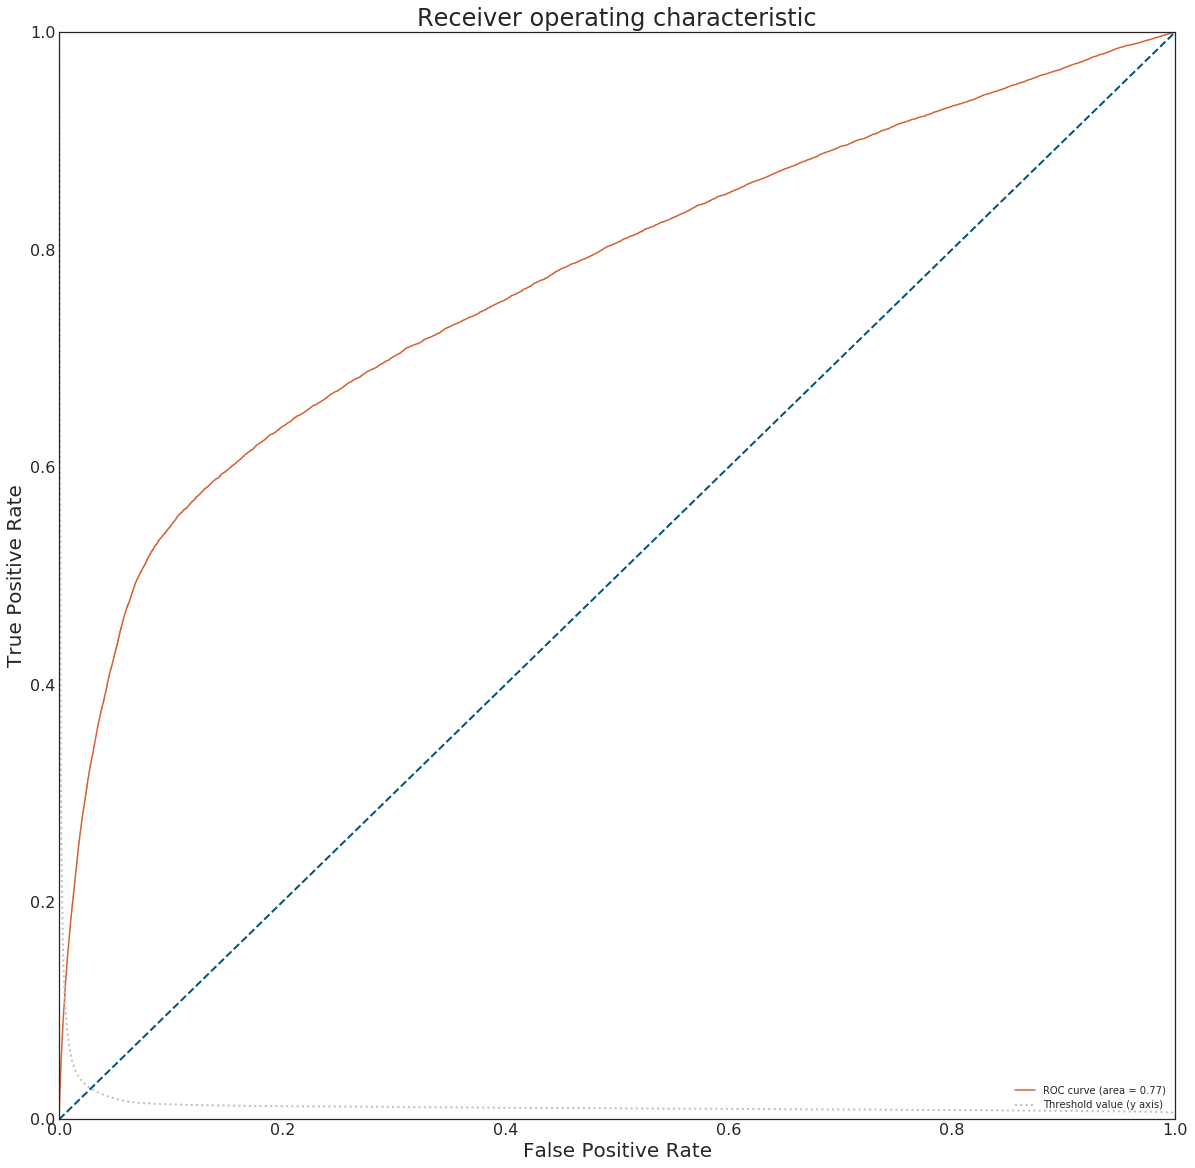

In [221]:
plot_roc(labels_test_2, probabilities_test_2)

## Lift Charts

### Training set

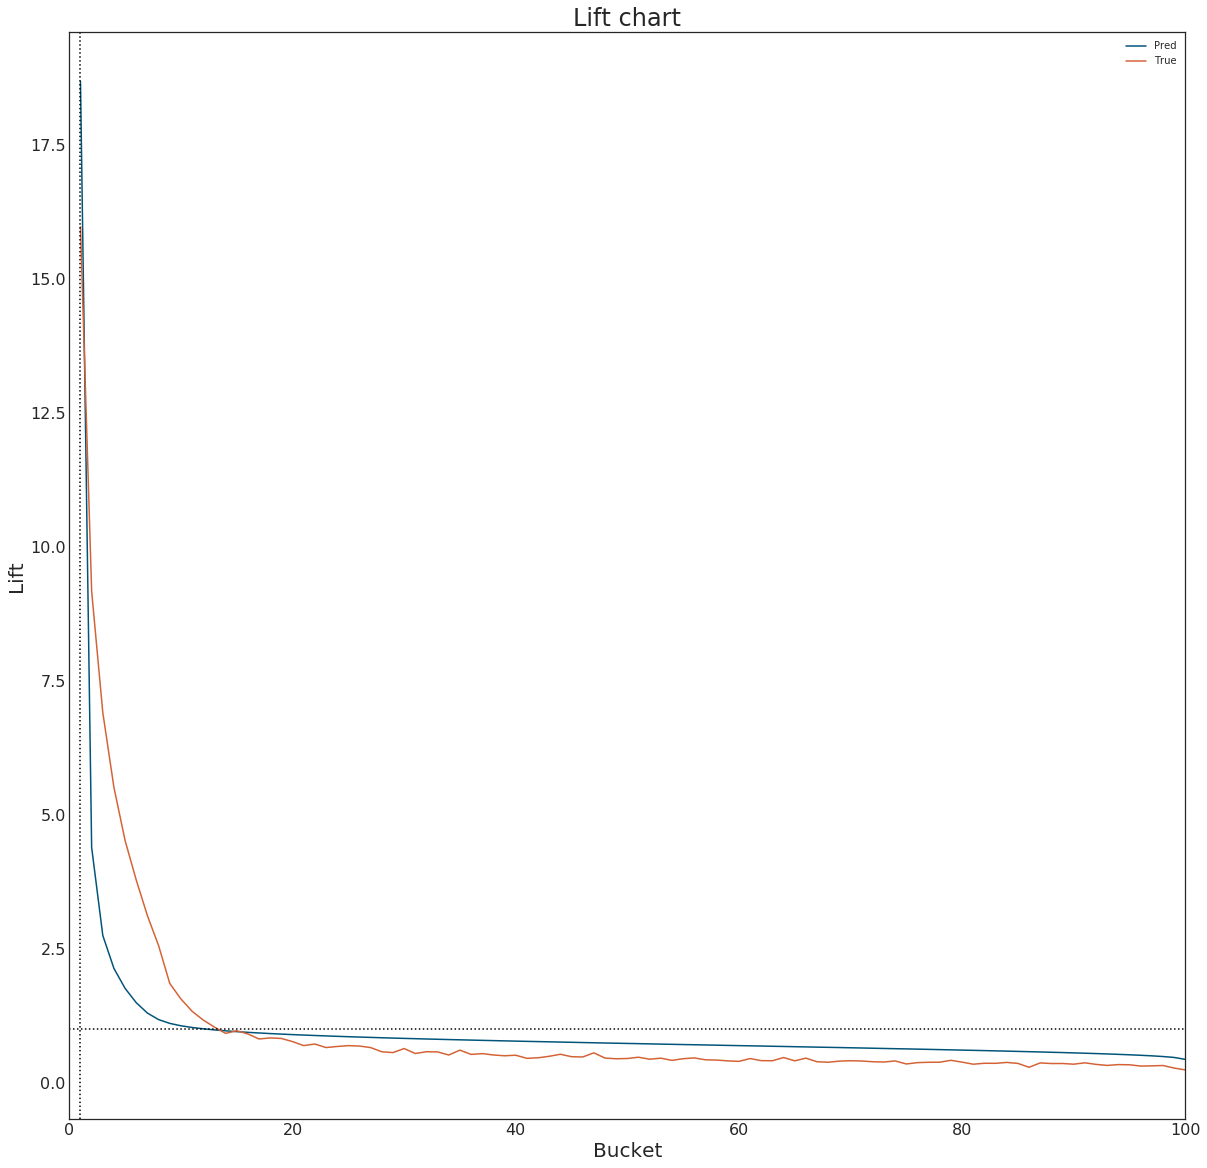

In [222]:
plot_lift(probabilities_train, 
          labels_train, 
          predictions_train, n_buckets=100)

### Test set 1

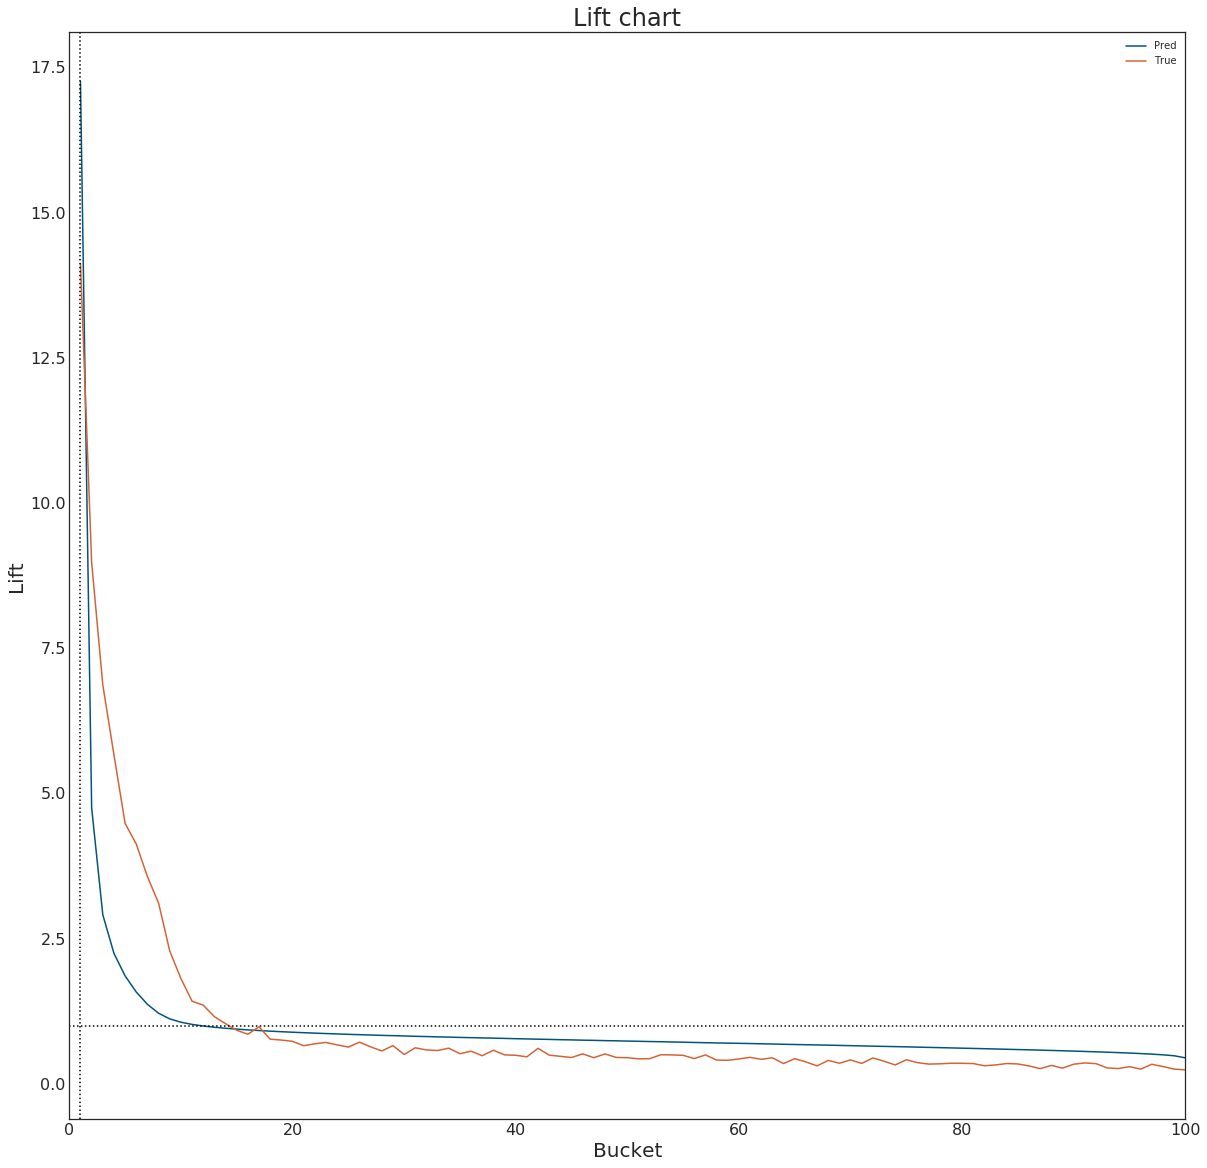

In [223]:
plot_lift(probabilities_test_1_adjusted, 
          labels_test_1, 
          predictions_test_1, n_buckets=100)

### Test set 2

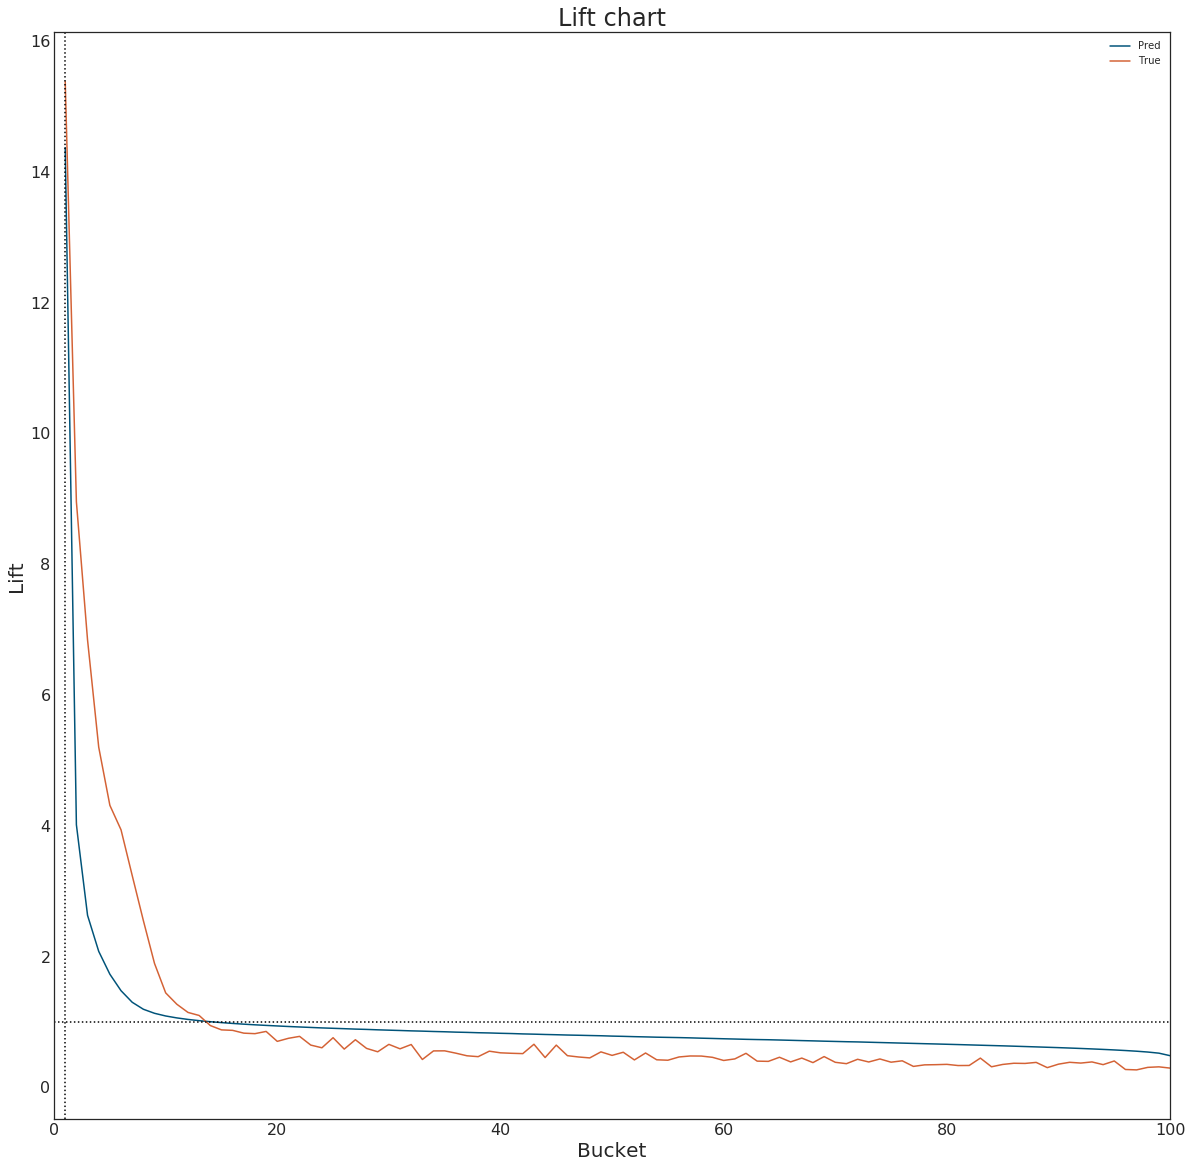

In [224]:
plot_lift(probabilities_test_2_adjusted, 
          labels_test_2, 
          predictions_test_2, n_buckets=100)

## Cumulative Gain

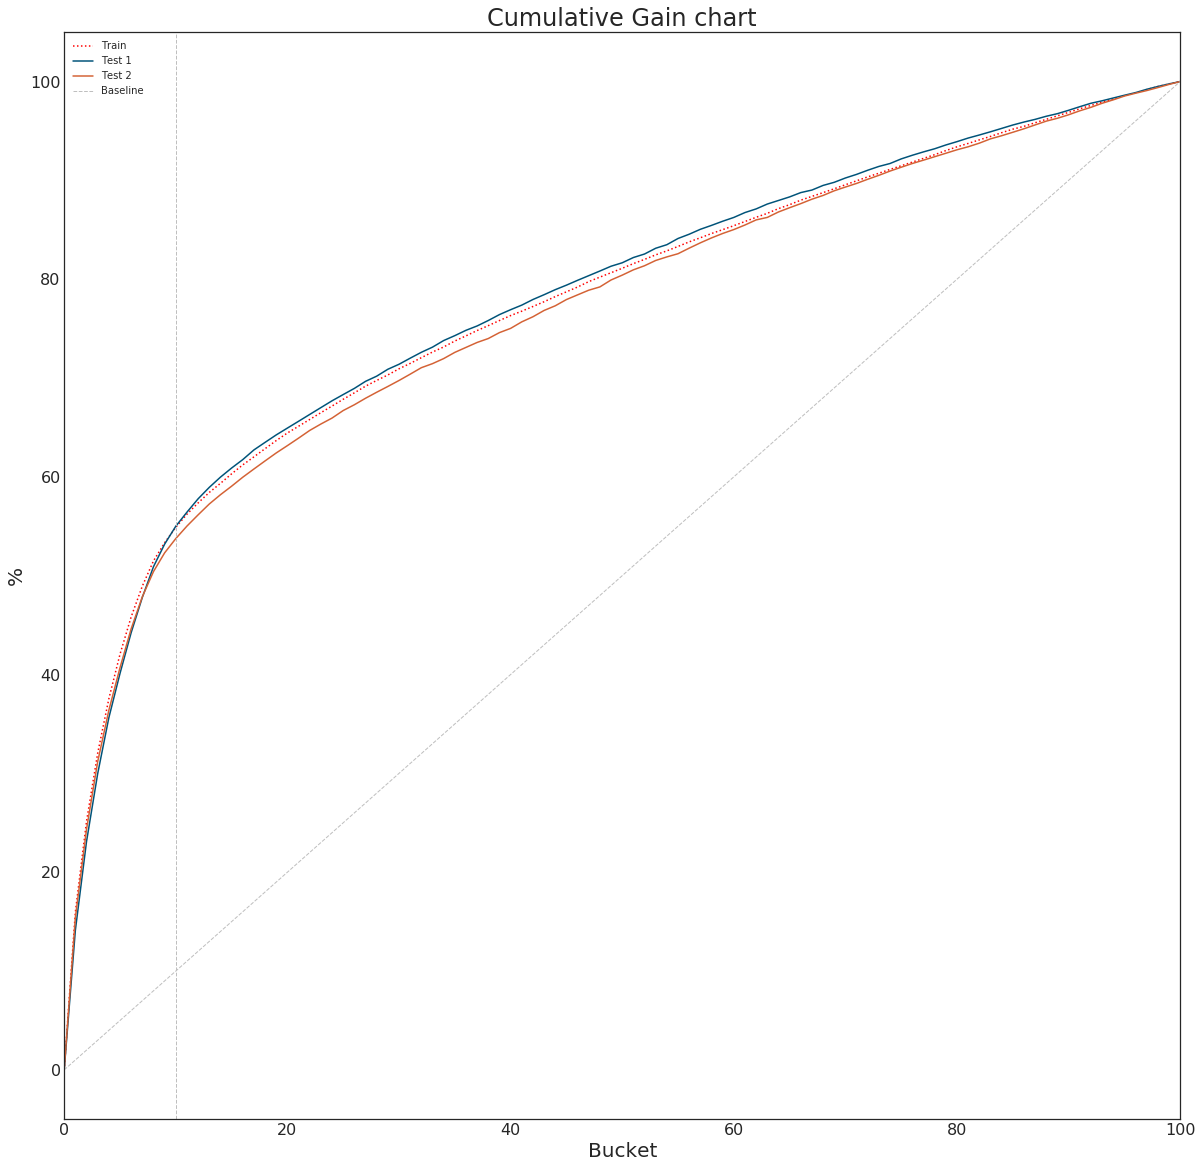

In [225]:
plot_cumulative_gains(results, n_buckets=100)

## Confusion Matrix

### Training set

In [226]:
display_confusion_matrix(predictions=predictions_train, true_labels=labels_train)

True label        
                           0       1
Predicted label 0    6816980  100012
                1       6638    4065

### Test set 1

In [227]:
display_confusion_matrix(predictions=predictions_test_1, true_labels=labels_test_1)

True label       
                           0      1
Predicted label 0    1966299  39154
                1       2520   1652

### Test set 2

In [228]:
display_confusion_matrix(predictions=predictions_test_2, true_labels=labels_test_2)

True label       
                           0      1
Predicted label 0    1476517  21980
                1       1236    724

## Accuracy

`(tp + tn) / (n_samples)`

### Training set

In [229]:
print("Accuracy on training set: {acc}".format(acc=accuracy_score(y_true=labels_train, y_pred=predictions_train)))

Accuracy on training set: 0.984605269140746


### Test set 1

In [230]:
print("Accuracy on test set 1: {acc}".format(acc=accuracy_score(y_true=labels_test_1, y_pred=predictions_test_1)))

Accuracy on test set 1: 0.9792627977856565


### Test set 2

In [231]:
print("Accuracy on test set 2: {acc}".format(acc=accuracy_score(y_true=labels_test_2, y_pred=predictions_test_2)))

Accuracy on test set 2: 0.9845273806580261


## Precision

`tp / (tp + fp)`

### Training set

In [232]:
print("Precision score on training set: {prec}".format(prec=precision_score(y_true=labels_train, y_pred=predictions_train)))

Precision score on training set: 0.3798000560590489


### Test set 1

In [233]:
print("Precision score on test set 1: {prec}".format(prec=precision_score(y_true=labels_test_1, y_pred=predictions_test_1)))

Precision score on test set 1: 0.3959731543624161


### Test set 2

In [234]:
print("Precision score on test set 2: {prec}".format(prec=precision_score(y_true=labels_test_2, y_pred=predictions_test_2)))

Precision score on test set 2: 0.3693877551020408


## Recall

`tp / (tp + fn)`

### Training set

In [235]:
print("Recall score on training set: {rec}".format(rec=recall_score(y_true=labels_train, y_pred=predictions_train)))

Recall score on training set: 0.03905762079998463


### Test set 1

In [236]:
print("Recall score on test set 1: {rec}".format(rec=recall_score(y_true=labels_test_1, y_pred=predictions_test_1)))

Recall score on test set 1: 0.04048424251335588


### Test set 2

In [237]:
print("Recall score on test set 2: {rec}".format(rec=recall_score(y_true=labels_test_2, y_pred=predictions_test_2)))

Recall score on test set 2: 0.031888653981677235


## F1

### Training set

In [238]:
print("F1 score on training set: {f1}".format(f1=f1_score(y_true=labels_train, y_pred=predictions_train)))

F1 score on training set: 0.0708311552535285


### Test set 1

In [239]:
print("F1 score on test set 1: {f1}".format(f1=f1_score(y_true=labels_test_1, y_pred=predictions_test_1)))

F1 score on test set 1: 0.07345813508826539


### Test set 2

In [240]:
print("F1 score on test set 2: {f1}".format(f1=f1_score(y_true=labels_test_2, y_pred=predictions_test_2)))

F1 score on test set 2: 0.0587090496269867


## AUC

### Training set

In [241]:
fpr, tpr, thr = roc_curve(labels_train, probabilities_train)
print("AUC on training set: {auc}".format(auc=auc(fpr, tpr)))

AUC on training set: 0.7786929906101716


### Test set 1

In [242]:
fpr, tpr, thr = roc_curve(labels_test_1, probabilities_test_1)
print("AUC on test set 1: {auc}".format(auc=auc(fpr, tpr)))

AUC on test set 1: 0.7838325763736806


### Test set 2

In [243]:
fpr, tpr, thr = roc_curve(labels_test_2, probabilities_test_2)
print("AUC on test set 2: {auc}".format(auc=auc(fpr, tpr)))

AUC on test set 2: 0.7717731498698637
